Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


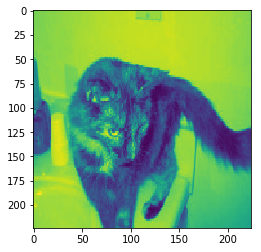

16471085.0


In [74]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 資料路徑
DATASET_PATH  = './data'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'
# 透過 data augmentation 產生訓練與驗證用的影像資料
datagen = ImageDataGenerator(validation_split=0.2)
train_generator = datagen.flow_from_directory(
    DATASET_PATH + '/train',
    subset='training',
    target_size=(224, 224),
    classes = ['dogs','cats']
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH + '/train',
    subset='validation',
    target_size=(224, 224),
    classes = ['dogs','cats']
)
#劃出灰階圖片
gray = cv2.cvtColor(train_generator[5][0][5], cv2.COLOR_RGB2GRAY)
plt.imshow(gray)
plt.show()
#train generator為批次載入圖片 一批次為長度32 此為訓練集 第一個數字為第幾組圖片  中間數字 1為lable,0為圖片像素 
#lable為one-hotcode表示
#訓練集有3200張圖片 所以第一個數字為0~99組  第三個數字為那一組的第幾張圖片 一組為32 所以第三個數字0~31
#觀察label
# print(train_generator[5][0][5]) 一張圖片
#print(train_generator[5][0][5][0][0]) 最後面兩個維度為圖片的[x][y]的三通到的pixel[0~255,0~255,0~255] 
print(np.sum(train_generator[5][0][8]))
# # 輸出各類別的索引值
# for cls, idx in train_generator.class_indices.items():
#     print('Class #{} = {}'.format(idx, cls))

# # 以訓練好的 ResNet50 為基礎來建立模型，
# # 捨棄 ResNet50 頂層的 fully connected layers
# net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
#                input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
# x = net.output
# x = Flatten()(x)

# # 增加 DropOut layer
# x = Dropout(0.5)(x)

# # 增加 Dense layer，以 softmax 產生個類別的機率值
# output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# # 設定凍結與要進行訓練的網路層
# net_final = Model(inputs=net.input, outputs=output_layer)
# for layer in net_final.layers[:FREEZE_LAYERS]:
#     layer.trainable = False
# for layer in net_final.layers[FREEZE_LAYERS:]:
#     layer.trainable = True

# # 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
# net_final.compile(optimizer=Adam(lr=1e-5),
#                   loss='categorical_crossentropy', metrics=['accuracy'])

# # 輸出整個網路結構
# print(net_final.summary())

# # 訓練模型
# net_final.fit_generator(train_generator,
#                         steps_per_epoch = train_generator.samples // BATCH_SIZE,
#                         validation_data = val_generator,
#                         validation_steps = val_generator.samples // BATCH_SIZE,
#                         epochs = NUM_EPOCHS)

# # 儲存訓練好的模型
# net_final.save(WEIGHTS_FINAL)



In [3]:
import keras
from keras import backend as K
from keras.models import Model,Sequential
from keras.layers import Flatten, Dense, Dropout,Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
%matplotlib inline
# 資料路徑
cats_path  = './data/train/cats'
dogs_path  = './data/train/dogs' 
# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

WEIGHTS_FINAL = 'model-resnet50-final.h5'

# Epoch 數
NUM_EPOCHS = 20
# 學習率動態調整。當跑到第幾個 epcoh 時，根據設定修改學習率。這邊的數值都是參考原 paper
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

cat_dog =[]
dog = []
removelist = []
lables = np.concatenate((np.ones(2000),np.zeros(2000)),axis=0)
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]),interpolation=cv2.INTER_CUBIC)
            images.append(img)
    return images
cat_dog = load_images_from_folder(cats_path)
dog = load_images_from_folder(dogs_path)
cat_dog = cat_dog+dog
for i in range(3999):
    temp = 0
    temp = np.sum(cat_dog[i])/1000
    if temp<10000 or temp>27000:
        removelist.append(i)
dog = []
for i in range(len(removelist)):
    cat_dog.pop(i)
lables = np.delete(lables,removelist)
cat_dog = np.array(cat_dog)
x_train, y_train, x_lable, y_lable = train_test_split(cat_dog, lables, test_size=0.2, random_state=42)
# 先把影像縮放到 0-1 之間
x_train = x_train.astype('float32') / 255
y_train = y_train.astype('float32') / 255


# 對 label 做 one-hot encoding
x_lable = keras.utils.to_categorical(x_lable, NUM_CLASSES)
y_lable = keras.utils.to_categorical(y_lable, NUM_CLASSES)


# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())    
# # 使用動態調整學習率
# lr_scheduler = LearningRateScheduler(lr_schedule)

# 使用自動降低學習率 (當 validation loss 連續 5 次沒有下降時，自動降低學習率)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
# 設定 callbacks
callbacks = [lr_reducer]

print('Using real-time data augmentation.')
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# 將資料送進 ImageDataGenrator 中做增強
datagen.fit(x_train)

# 訓練模型囉！
net_final.fit_generator(datagen.flow(x_train, x_lable, batch_size=BATCH_SIZE),
                    steps_per_epoch=int(len(x_train)//BATCH_SIZE),
                    validation_data=(y_train, y_lable),
                    validation_steps =int(len(y_train)//BATCH_SIZE),
                    epochs=NUM_EPOCHS, verbose=1, workers=4,
                    shuffle=True,
                    callbacks=callbacks)
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)
# 評估我們的模型
scores = net_final.evaluate(y_train, y_lable, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
#除以1000後 一萬以下 與二萬七千以上移除

C:\Users\max76\.conda\envs\tensorflow-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Epoch 1/20
381/381 [==============================] - 80s 211ms/step - loss: 0.7833 - acc: 0.7694 - val_loss: 0.3185 - val_acc: 0.9253
Epoch 2/20
381/381 [==============================] - 73s 191ms/step - loss: 0.4516 - acc: 0.8855 - val_loss: 0.3176 - val_acc: 0.9358
Epoch 3/20
381/381 [==============================] - 73s 192ms/step - loss: 0.3284 - acc: 0.9144 - val_loss: 0.3008 - val_acc: 0.9397
Epoch 4/20
 83/381 [=====>........................] - ETA: 53s - loss: 0.3339 - acc: 0.9202

KeyboardInterrupt: 

In [2]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
import sys
import numpy as np
import os
import cv2
import pandas as pd
test_path  = './data/test' 
net = load_model('model-resnet50-finalV3.h5')
list_labels = ['ID', 'Predicted']
ID = []
Predicted = []
# list_cols = [cities, weekdays, visitors]
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img, (224,224),interpolation=cv2.INTER_CUBIC)
            img = np.reshape(img,(1,224,224,3))
            images.append(img)
    return images
test_image = load_images_from_folder(test_path)
test_image = np.array(test_image)
# 先把影像縮放到 0-1 之間
test_image = test_image.astype('float32') / 255
# for i in range(10):
#     pred = net.predict(test_image[i])
#     pred = np.reshape(pred,(2,))
#     print('{0:.5f}'.format(pred[1]))
for i in range(len(test_image)):
    pred = net.predict(test_image[i])
    pred = np.reshape(pred,(2,))
    ID.append(i)
    Predicted.append(pred[1])
list_cols = [ID,Predicted]   
zipped = list(zip(list_labels, list_cols))
cat_dogPred = pd.DataFrame(dict(zipped))
cat_dogPred.to_csv("cat_dogPredV3.csv", index=False)

In [1]:
import keras
from keras import backend as K
from keras.models import Model,Sequential
from keras.layers import Flatten, Dense, Dropout,Conv2D, MaxPooling2D,BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
%matplotlib inline
# 資料路徑
cats_path  = './data/train/cats'
dogs_path  = './data/train/dogs' 
# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 16

# 凍結網路層數
FREEZE_LAYERS = 2

WEIGHTS_FINAL = 'model-resnet50-finalV3.h5'

# Epoch 數
NUM_EPOCHS = 30
# 學習率動態調整。當跑到第幾個 epcoh 時，根據設定修改學習率。這邊的數值都是參考原 paper
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

cat_dog =[]
dog = []
removelist = []
lables = np.concatenate((np.ones(2000),np.zeros(2000)),axis=0)
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]),interpolation=cv2.INTER_CUBIC)
            images.append(img)
    return images
#從資料夾讀取圖片
cat_dog = load_images_from_folder(cats_path)
dog = load_images_from_folder(dogs_path)
#合併train data貓狗圖片
cat_dog = cat_dog+dog
#把圖片異常值篩選掉
for i in range(3999):
    temp = 0
    temp = np.sum(cat_dog[i])/1000
    if temp<10000 or temp>27000:
        removelist.append(i)
dog = []
for i in range(len(removelist)):
    cat_dog.pop(i)
lables = np.delete(lables,removelist)
cat_dog = np.array(cat_dog)
x_train, y_train, x_lable, y_lable = train_test_split(cat_dog, lables, test_size=0.2, random_state=42)
# 先把影像縮放到 0-1 之間
x_train = x_train.astype('float32') / 255
y_train = y_train.astype('float32') / 255


# 對 label 做 one-hot encoding
x_lable = keras.utils.to_categorical(x_lable, NUM_CLASSES)
y_lable = keras.utils.to_categorical(y_lable, NUM_CLASSES)


# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)
# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())    
# # 使用動態調整學習率
# lr_scheduler = LearningRateScheduler(lr_schedule)

# 使用自動降低學習率 (當 validation loss 連續 5 次沒有下降時，自動降低學習率)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
# 設定 callbacks
callbacks = [lr_reducer]

print('Using real-time data augmentation.')
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# 將資料送進 ImageDataGenrator 中做增強
datagen.fit(x_train)

# 訓練模型囉！
net_final.fit_generator(datagen.flow(x_train, x_lable, batch_size=BATCH_SIZE),
                    steps_per_epoch=int(len(x_train)//BATCH_SIZE),
                    validation_data=(y_train, y_lable),
                    validation_steps =int(len(y_train)//BATCH_SIZE),
                    epochs=NUM_EPOCHS, verbose=1, workers=4,
                    shuffle=True,
                    callbacks=callbacks)
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)
# 評估我們的模型
scores = net_final.evaluate(y_train, y_lable, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
#除以1000後 一萬以下 與二萬七千以上移除

Using TensorFlow backend.
W0818 06:53:03.640852 13824 deprecation_wrapper.py:119] From C:\Users\max76\.conda\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 06:53:03.670772 13824 deprecation_wrapper.py:119] From C:\Users\max76\.conda\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 06:53:03.680746 13824 deprecation_wrapper.py:119] From C:\Users\max76\.conda\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0818 06:53:03.699726 13824 deprecation_wrapper.py:119] From C:\Users\max76\.conda\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Pleas

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

W0818 06:53:11.511899 13824 deprecation.py:323] From C:\Users\max76\.conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
190/190 [==============================] - 70s 366ms/step - loss: 0.7864 - acc: 0.7701 - val_loss: 0.3398 - val_acc: 0.9056
Epoch 2/30
190/190 [==============================] - 60s 317ms/step - loss: 0.4311 - acc: 0.8832 - val_loss: 0.2920 - val_acc: 0.9305
Epoch 3/30
190/190 [==============================] - 59s 312ms/step - loss: 0.3260 - acc: 0.9202 - val_loss: 0.2862 - val_acc: 0.9410
Epoch 4/30
190/190 [==============================] - 59s 312ms/step - loss: 0.2802 - acc: 0.9239 - val_loss: 0.2838 - val_acc: 0.9397
Epoch 5/30
190/190 [==============================] - 59s 312ms/step - loss: 0.2323 - acc: 0.9384 - val_loss: 0.2869 - val_acc: 0.9358
Epoch 6/30
190/190 [==============================] - 59s 312ms/step - loss: 0.2158 - acc: 0.9408 - val_loss: 0.2864 - val_acc: 0.9436
Epoch 7/30
190/190 [==============================] - 59s 313ms/step - loss: 0.1699 - acc: 0.9520 - val_loss: 0.2770 - val_acc: 0.9489
Epoch 8/30
190/190 [==============================] - 5